## XGBoost Classification Model
XGBoost (Extreme Gradient Boosting) model for predicting user activity. This model uses gradient boosting with tree-based learning algorithms to classify users as active or inactive based on their engagement patterns, demographics, and behavior features.

### 1. Imports

In [47]:
# Core data manipulation and numerical computing
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold,
    RandomizedSearchCV
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay, classification_report,
    precision_score, recall_score, f1_score, confusion_matrix,
    make_scorer
)
from scipy.stats import uniform, randint

# XGBoost
import xgboost as xgb

# Optional: SHAP for interpretability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("Note: SHAP not available. Install with 'pip install shap' for interpretability analysis.")

print("✓ All packages loaded successfully")

✓ All packages loaded successfully


### 2. Loading Data

In [48]:
print("\nLoading user-level data...")
df = pd.read_csv(Path("../data/user_level_data.csv"))
y = df["y_active"].astype(int)

print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")

# Drop identifier columns and target variable
drop_cols = [c for c in ["y_active", "userId"] if c in df.columns]
X = df.drop(columns=drop_cols, errors="ignore")
X = X.drop(columns=["usr_total_impressions"], errors="ignore")
print(f"Features after dropping identifiers: {X.shape[1]}")


Loading user-level data...
Dataset shape: (20011, 31)
Target distribution:
y_active
0    0.711109
1    0.288891
Name: proportion, dtype: float64
Features after dropping identifiers: 29


### 3. Preprocessing

In [59]:
# Data splitting at user level
print("\n" + "="*60)
print("TRAIN/VALIDATION/TEST SPLITS (User-level)")
print("="*60)

# Drop identifier columns and target variable
drop_cols = [c for c in ["y_active", "userId"] if c in df.columns]
X = df.drop(columns=drop_cols, errors="ignore")
X = X.drop(columns=["usr_total_impressions"], errors="ignore")

# Drop usr_actions_taken to test if early action QUALITY (not just count) can predict activity
# This addresses the circularity concern: removing the threshold feature to see if 
# action quality features (likes, shares, clicks, dwell time) alone are predictive
X = X.drop(columns=["usr_actions_taken"], errors="ignore")

print(f"Features after dropping identifiers and usr_actions_taken: {X.shape[1]}")

# First split: 80% train+valid, 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Second split: 80% train, 20% valid (of the train_full set)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=42, stratify=y_train_full
)

print(f"Train: {X_train.shape[0]}, Valid: {X_valid.shape[0]}, Test: {X_test.shape[0]}")
print(f"Train distribution: {y_train.value_counts(normalize=True).to_dict()}")


TRAIN/VALIDATION/TEST SPLITS (User-level)
Features after dropping identifiers and usr_actions_taken: 28
Train: 12806, Valid: 3202, Test: 4003
Train distribution: {0: 0.7110729345619241, 1: 0.2889270654380759}


In [60]:
# === Remove Highly Correlated Features (on training set only) ===
print("\n" + "="*60)
print("CORRELATION-BASED FEATURE SELECTION")
print("="*60)

# Calculate correlation matrix for numerical features only
num_cols_for_corr = X_train.select_dtypes(include=[np.number]).columns
if len(num_cols_for_corr) > 1:
    corr_matrix = X_train[num_cols_for_corr].corr().abs()
    
    # Find pairs with correlation > 0.95
    upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    high_corr_pairs = corr_matrix.where(upper_triangle).stack()
    high_corr_pairs = high_corr_pairs[high_corr_pairs > 0.95]
    
    if len(high_corr_pairs) > 0:
        # Remove one feature from each highly correlated pair
        # Keep the feature with higher correlation to target
        to_remove = set()
        for (feat1, feat2), corr_val in high_corr_pairs.items():
            if feat1 not in to_remove and feat2 not in to_remove:
                # Check correlation with target
                corr1_target = abs(X_train[feat1].corr(y_train))
                corr2_target = abs(X_train[feat2].corr(y_train))
                # Remove the one with lower correlation to target
                if corr1_target < corr2_target:
                    to_remove.add(feat1)
                else:
                    to_remove.add(feat2)
        
        if to_remove:
            X_train = X_train.drop(columns=list(to_remove), errors="ignore")
            X_valid = X_valid.drop(columns=list(to_remove), errors="ignore")
            X_test = X_test.drop(columns=list(to_remove), errors="ignore")
            print(f"Removed {len(to_remove)} highly correlated features: {list(to_remove)[:10]}...")
    else:
        print("No highly correlated features found (threshold: 0.95)")

# Identify categorical and numerical features
cat_cols = list(X_train.select_dtypes(include=["object","category","string","bool"]).columns)
# Treat low-cardinality integer columns as categorical
for c in X_train.select_dtypes(include=["int16","int32","int64","Int8","Int16","Int32","Int64","uint8","uint16"]).columns:
    if X_train[c].nunique(dropna=True) <= 20 and c not in cat_cols:
        cat_cols.append(c)
num_cols = [c for c in X_train.columns if c not in cat_cols]

print(f"\nCategorical features: {len(cat_cols)}")
print(f"Numerical features: {len(num_cols)}")

# Create preprocessing pipeline:
# - Numerical: Impute missing values with median
# - Categorical: Impute missing values with mode, then one-hot encode
print("\nFitting preprocessor...")
try:
    oh_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, min_frequency=0.01)
except TypeError:
    oh_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

pre = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("oh", oh_encoder)
        ]), cat_cols),
    ],
    remainder="drop"
)

X_train_t = pre.fit_transform(X_train, y_train)
X_valid_t = pre.transform(X_valid)
X_test_t  = pre.transform(X_test)

print(f"Transformed shapes - Train: {X_train_t.shape}, Valid: {X_valid_t.shape}, Test: {X_test_t.shape}")

oh = pre.named_transformers_["cat"].named_steps["oh"] if len(cat_cols) else None
cat_names = oh.get_feature_names_out(cat_cols) if oh is not None else np.array([])
num_names = np.array(num_cols)
feature_names = list(num_names) + list(cat_names)


CORRELATION-BASED FEATURE SELECTION
No highly correlated features found (threshold: 0.95)

Categorical features: 10
Numerical features: 18

Fitting preprocessor...
Transformed shapes - Train: (12806, 64), Valid: (3202, 64), Test: (4003, 64)


### 4. Hyperparameter Tuning

In [61]:
# Hyperparameter Tuning using RandomizedSearchCV
print("\n" + "="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

# Handle class imbalance by adjusting scale_pos_weight
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = (neg / max(pos, 1))

print(f"Class imbalance - Pos: {pos}, Neg: {neg}, Scale weight: {scale_pos_weight:.3f}")

# Base parameters
base_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
    "scale_pos_weight": scale_pos_weight,
    "seed": 42,
    "n_jobs": -1,
}

# Parameter distribution for randomized search
param_distributions = {
    "learning_rate": uniform(0.01, 0.05),  # 0.01 to 0.06
    "max_depth": randint(3, 8),            # 3 to 7
    "subsample": uniform(0.7, 0.25),      # 0.7 to 0.95
    "colsample_bytree": uniform(0.7, 0.25), # 0.7 to 0.95
    "colsample_bylevel": uniform(0.7, 0.25), # 0.7 to 0.95
    "reg_alpha": uniform(0, 1.0),         # 0 to 1.0
    "reg_lambda": uniform(1.0, 4.0),      # 1.0 to 5.0
    "min_child_weight": uniform(1, 3),     # 1 to 4
    "gamma": uniform(0, 0.3),              # 0 to 0.3
}

print("\nPerforming RandomizedSearchCV (this may take a few minutes)...")
print(f"Searching {50} parameter combinations with 3-fold CV...")

# Use XGBClassifier for compatibility with RandomizedSearchCV
# Note: eval_metric is only for native XGBoost API, not sklearn's XGBClassifier
base_params_sklearn = {k: v for k, v in base_params.items() if k != 'eval_metric'}
xgb_base = xgb.XGBClassifier(**base_params_sklearn)

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    cv=3,       # 3-fold cross-validation
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit the search
print("Fitting RandomizedSearchCV...")
random_search.fit(X_train_t, y_train)

# Get best parameters
best_params = random_search.best_params_
params = {**base_params, **best_params}

print("\n" + "="*60)
print("BEST PARAMETERS FROM RANDOMIZED SEARCH:")
print("="*60)
for key, value in sorted(params.items()):
    if key not in ['n_jobs']:  # Skip non-essential parameters in display
        print(f"{key}: {value}")

print(f"\nBest CV Score (ROC AUC): {random_search.best_score_:.4f}")
print(f"Best iteration index: {random_search.best_index_}")
print("✓ Hyperparameter tuning complete")


HYPERPARAMETER TUNING
Class imbalance - Pos: 3700, Neg: 9106, Scale weight: 2.461

Performing RandomizedSearchCV (this may take a few minutes)...
Searching 50 parameter combinations with 3-fold CV...
Fitting RandomizedSearchCV...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

BEST PARAMETERS FROM RANDOMIZED SEARCH:
colsample_bylevel: 0.7192449774571982
colsample_bytree: 0.772437863228442
eval_metric: auc
gamma: 0.04836638617620132
learning_rate: 0.05648488261712866
max_depth: 7
min_child_weight: 1.886901057513142
objective: binary:logistic
reg_alpha: 0.10549425983027061
reg_lambda: 2.826138281931641
scale_pos_weight: 2.461081081081081
seed: 42
subsample: 0.7546101093042084
tree_method: hist

Best CV Score (ROC AUC): 0.9310
Best iteration index: 12
✓ Hyperparameter tuning complete


### 5. Train Final Model on Full Training Set
Train the final model on the complete training set (train + validation combined) using the best hyperparameters found during tuning.


In [62]:
### 5. Train Final Model on Full Training Set

# Train final model on full training set (train + validation combined)
print("\n" + "="*60)
print("TRAINING FINAL MODEL ON FULL TRAINING SET")
print("="*60)

# Combine train and validation sets
X_train_final = np.vstack([X_train_t, X_valid_t])
y_train_final = np.hstack([y_train.values, y_valid.values])

print(f"Final training set size: {X_train_final.shape[0]}")

# Create DMatrix for final training
dtrain_final = xgb.DMatrix(X_train_final, label=y_train_final, feature_names=feature_names)
dvalid_final = xgb.DMatrix(X_valid_t, label=y_valid, feature_names=feature_names)  # Keep for early stopping
dtest_final = xgb.DMatrix(X_test_t, label=y_test, feature_names=feature_names)

print("\nTraining final XGBoost model on full training set...")
evals = [(dtrain_final, "train"), (dvalid_final, "valid")]
booster_final = xgb.train(
    params=params,
    dtrain=dtrain_final,
    num_boost_round=2500,
    evals=evals,
    early_stopping_rounds=100,
    verbose_eval=50,
)

print(f"\nBest iteration: {booster_final.best_iteration}")
print(f"Best validation AUC: {booster_final.best_score:.4f}")

# Use final model for all subsequent evaluations
booster = booster_final
dvalid = dvalid_final  # Create alias for consistency with evaluation code
dtest = dtest_final  # Create alias for consistency with evaluation code



TRAINING FINAL MODEL ON FULL TRAINING SET
Final training set size: 16008

Training final XGBoost model on full training set...
[0]	train-auc:0.92805	valid-auc:0.93192
[50]	train-auc:0.95549	valid-auc:0.95853
[100]	train-auc:0.96833	valid-auc:0.97011
[150]	train-auc:0.97731	valid-auc:0.97855
[200]	train-auc:0.98405	valid-auc:0.98510
[250]	train-auc:0.98857	valid-auc:0.98931
[300]	train-auc:0.99254	valid-auc:0.99321
[350]	train-auc:0.99508	valid-auc:0.99595
[400]	train-auc:0.99685	valid-auc:0.99753
[450]	train-auc:0.99801	valid-auc:0.99852
[500]	train-auc:0.99875	valid-auc:0.99909
[550]	train-auc:0.99921	valid-auc:0.99947
[600]	train-auc:0.99955	valid-auc:0.99971
[650]	train-auc:0.99975	valid-auc:0.99985
[700]	train-auc:0.99986	valid-auc:0.99990
[750]	train-auc:0.99992	valid-auc:0.99995
[800]	train-auc:0.99995	valid-auc:0.99998
[850]	train-auc:0.99998	valid-auc:1.00000
[900]	train-auc:0.99999	valid-auc:1.00000
[950]	train-auc:0.99999	valid-auc:1.00000
[1000]	train-auc:1.00000	valid-auc:

In [ ]:
###  Cross-Validation for Robustness Assessment

# Cross-Validation for Robustness Assessment
# Note: This cross-validation is performed independently on the training+validation set
# to assess model stability and generalization capability. It uses the same hyperparameters
# found during tuning but trains separate models on different folds to evaluate consistency.
print("\n" + "="*60)
print("CROSS-VALIDATION (5-Fold) - Robustness Assessment")
print("="*60)

# Combine train and validation sets for CV
X_train_cv = np.vstack([X_train_t, X_valid_t])
y_train_cv = np.hstack([y_train.values, y_valid.values])

# Create CV folds
cv_folds = 5
skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

cv_auc_scores = []
cv_pr_scores = []
cv_f1_scores = []

print(f"Performing {cv_folds}-fold cross-validation on training set...")
print("This helps assess model stability before training the final model.\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_cv, y_train_cv), 1):
    X_cv_train, X_cv_val = X_train_cv[train_idx], X_train_cv[val_idx]
    y_cv_train, y_cv_val = y_train_cv[train_idx], y_train_cv[val_idx]
    
    # Create DMatrix
    dtrain_cv = xgb.DMatrix(X_cv_train, label=y_cv_train, feature_names=feature_names)
    dval_cv = xgb.DMatrix(X_cv_val, label=y_cv_val, feature_names=feature_names)
    
    # Train model
    model_cv = xgb.train(
        params=params,
        dtrain=dtrain_cv,
        num_boost_round=2500,
        evals=[(dval_cv, "val")],
        early_stopping_rounds=100,
        verbose_eval=False,
    )
    
    # Predict and evaluate
    y_pred_cv = model_cv.predict(dval_cv)
    auc_cv = roc_auc_score(y_cv_val, y_pred_cv)
    pr_cv = average_precision_score(y_cv_val, y_pred_cv)
    
    # F1 score with optimal threshold
    pred_cv_binary = (y_pred_cv >= 0.5).astype(int)
    f1_cv = f1_score(y_cv_val, pred_cv_binary)
    
    cv_auc_scores.append(auc_cv)
    cv_pr_scores.append(pr_cv)
    cv_f1_scores.append(f1_cv)
    
    print(f"Fold {fold}: ROC AUC = {auc_cv:.4f}, PR AUC = {pr_cv:.4f}, F1 = {f1_cv:.4f}")

print(f"\n" + "="*60)
print("CROSS-VALIDATION SUMMARY")
print("="*60)
print(f"ROC AUC: {np.mean(cv_auc_scores):.4f} (+/- {np.std(cv_auc_scores):.4f})")
print(f"PR AUC:  {np.mean(cv_pr_scores):.4f} (+/- {np.std(cv_pr_scores):.4f})")
print(f"F1-Score: {np.mean(cv_f1_scores):.4f} (+/- {np.std(cv_f1_scores):.4f})")

# Assess stability
cv_stability = "Excellent" if np.std(cv_auc_scores) < 0.01 else "Good" if np.std(cv_auc_scores) < 0.02 else "Fair"
print(f"\nCV Stability: {cv_stability} (std: {np.std(cv_auc_scores):.4f})")
print("✓ Cross-validation complete. Proceeding to final model training...")


CROSS-VALIDATION (5-Fold) - Robustness Assessment
Performing 5-fold cross-validation on training set...
This helps assess model stability before training the final model.

Fold 1: ROC AUC = 0.9306, PR AUC = 0.8069, F1 = 0.7901
Fold 2: ROC AUC = 0.9280, PR AUC = 0.7967, F1 = 0.7803
Fold 3: ROC AUC = 0.9357, PR AUC = 0.8198, F1 = 0.7978
Fold 4: ROC AUC = 0.9342, PR AUC = 0.8205, F1 = 0.7879
Fold 5: ROC AUC = 0.9307, PR AUC = 0.8021, F1 = 0.7897

CROSS-VALIDATION SUMMARY
ROC AUC: 0.9318 (+/- 0.0028)
PR AUC:  0.8092 (+/- 0.0095)
F1-Score: 0.7891 (+/- 0.0056)

CV Stability: Excellent (std: 0.0028)
✓ Cross-validation complete. Proceeding to final model training...


### 6. Evaluation

In [64]:
### 6.1. Threshold Optimization

# Threshold optimization
# Optimize classification threshold on validation set to balance precision and recall
# Different thresholds are evaluated based on F1-score, precision, recall, business cost, and Youden's J
print("\n" + "="*60)
print("THRESHOLD OPTIMIZATION")
print("="*60)

proba_valid = booster.predict(dvalid)
thresholds = np.arange(0.2, 0.8, 0.01)
f1_scores = []
recall_scores = []
precision_scores = []
# Business-aligned metrics
cost_fn_weight = 2.0  # Cost of missing an active user vs wasting intervention
business_scores = []

for threshold in thresholds:
    pred_valid = (proba_valid >= threshold).astype(int)
    f1_scores.append(f1_score(y_valid, pred_valid))
    recall_scores.append(recall_score(y_valid, pred_valid))
    precision_scores.append(precision_score(y_valid, pred_valid))
    
    # Business cost: minimize weighted cost
    tn, fp, fn, tp = confusion_matrix(y_valid, pred_valid).ravel()
    cost = fp + cost_fn_weight * fn
    business_scores.append(-cost)

# Find optimal thresholds
optimal_f1_idx = np.argmax(f1_scores)
optimal_f1_threshold = thresholds[optimal_f1_idx]
optimal_f1 = f1_scores[optimal_f1_idx]

optimal_precision_idx = np.argmax(precision_scores)
optimal_precision_threshold = thresholds[optimal_precision_idx]

optimal_recall_idx = np.argmax(recall_scores)
optimal_recall_threshold = thresholds[optimal_recall_idx]

optimal_business_idx = np.argmax(business_scores)
optimal_business_threshold = thresholds[optimal_business_idx]

# Youden's J statistic
youden_scores = []
for threshold in thresholds:
    pred_valid = (proba_valid >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_valid, pred_valid).ravel()
    tpr_val = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0
    youden_scores.append(tpr_val - fpr_val)
optimal_youden_idx = np.argmax(youden_scores)
optimal_youden_threshold = thresholds[optimal_youden_idx]

print(f"Optimal threshold (F1): {optimal_f1_threshold:.3f} (F1: {optimal_f1:.4f})")
print(f"Optimal threshold (Precision): {optimal_precision_threshold:.3f} (Precision: {precision_scores[optimal_precision_idx]:.4f})")
print(f"Optimal threshold (Recall): {optimal_recall_threshold:.3f} (Recall: {recall_scores[optimal_recall_idx]:.4f})")
print(f"Optimal threshold (Business Cost, FN={cost_fn_weight}x): {optimal_business_threshold:.3f}")
print(f"Optimal threshold (Youden's J): {optimal_youden_threshold:.3f}")

default_idx = np.abs(thresholds - 0.5).argmin()
print(f"\nDefault threshold (0.5) - F1: {f1_scores[default_idx]:.4f}, "
      f"Recall: {recall_scores[default_idx]:.4f}, "
      f"Precision: {precision_scores[default_idx]:.4f}")

# Use F1-optimal as default
optimal_threshold = optimal_f1_threshold


THRESHOLD OPTIMIZATION
Optimal threshold (F1): 0.660 (F1: 1.0000)
Optimal threshold (Precision): 0.660 (Precision: 1.0000)
Optimal threshold (Recall): 0.200 (Recall: 1.0000)
Optimal threshold (Business Cost, FN=2.0x): 0.660
Optimal threshold (Youden's J): 0.660

Default threshold (0.5) - F1: 0.9946, Recall: 1.0000, Precision: 0.9893


In [65]:
### 6.2. Model Evaluation on Test Set

# Model evaluation on test set
# Evaluate the final model on the held-out test set using both default (0.5) and optimized thresholds
proba = booster.predict(dtest)
pred_default = (proba >= 0.5).astype(int)
pred_optimal = (proba >= optimal_threshold).astype(int)

print("\n" + "="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)

# === User-level Metrics ===
print("\n--- Default Threshold (0.5) ---")
roc_auc_default = roc_auc_score(y_test, proba)
pr_auc_default = average_precision_score(y_test, proba)
print(f"Hold-out ROC AUC: {round(roc_auc_default, 4)}")
print(f"Hold-out PR  AUC: {round(pr_auc_default, 4)}")

print("\nClassification Report:")
print(classification_report(y_test, pred_default, digits=3))

print(f"\n--- Optimal Threshold ({optimal_threshold:.3f}, F1-optimized) ---")
roc_auc_optimal = roc_auc_score(y_test, proba)
pr_auc_optimal = average_precision_score(y_test, proba)
print(f"Hold-out ROC AUC: {round(roc_auc_optimal, 4)}")
print(f"Hold-out PR  AUC: {round(pr_auc_optimal, 4)}")
print(f"\nClassification report:\n{classification_report(y_test, pred_optimal, digits=3)}")

cm_default = confusion_matrix(y_test, pred_default)
cm_optimal = confusion_matrix(y_test, pred_optimal)

print("\n" + "="*60)
print("\nConfusion Matrix:")
print(f"\nConfusion Matrix (Threshold=0.5):\n{cm_default}")
print(f"\nConfusion Matrix (Threshold={optimal_threshold:.3f}):\n{cm_optimal}")

# === Business Metrics ===
print("\n" + "="*60)
print("BUSINESS METRICS")
print("="*60)

def calculate_business_metrics(y_true, y_pred, proba, cost_fn_weight=2.0):
    """Calculate business-aligned metrics"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    metrics = {
        'True Positives (TP)': tp,
        'True Negatives (TN)': tn,
        'False Positives (FP)': fp,
        'False Negatives (FN)': fn,
        'Total Cost (FP + {}xFN)'.format(cost_fn_weight): fp + cost_fn_weight * fn,
        'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'Recall (Sensitivity)': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'F1-Score': 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0,
    }
    return metrics

print("\n--- Default Threshold (0.5) ---")
business_metrics_default = calculate_business_metrics(y_test, pred_default, proba, cost_fn_weight)
for metric, value in business_metrics_default.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")

print(f"\n--- Optimal Threshold ({optimal_threshold:.3f}) ---")
business_metrics_optimal = calculate_business_metrics(y_test, pred_optimal, proba, cost_fn_weight)
for metric, value in business_metrics_optimal.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")


MODEL PERFORMANCE METRICS

--- Default Threshold (0.5) ---
Hold-out ROC AUC: 0.9314
Hold-out PR  AUC: 0.8062

Classification Report:
              precision    recall  f1-score   support

           0      0.942     0.855     0.896      2847
           1      0.709     0.869     0.781      1156

    accuracy                          0.859      4003
   macro avg      0.825     0.862     0.839      4003
weighted avg      0.875     0.859     0.863      4003


--- Optimal Threshold (0.660, F1-optimized) ---
Hold-out ROC AUC: 0.9314
Hold-out PR  AUC: 0.8062

Classification report:
              precision    recall  f1-score   support

           0      0.908     0.878     0.893      2847
           1      0.722     0.781     0.750      1156

    accuracy                          0.850      4003
   macro avg      0.815     0.829     0.821      4003
weighted avg      0.854     0.850     0.852      4003



Confusion Matrix:

Confusion Matrix (Threshold=0.5):
[[2435  412]
 [ 151 1005]]

Confus


ROC-AUC Score and Curve:

Precision-Recall Curve:

COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS


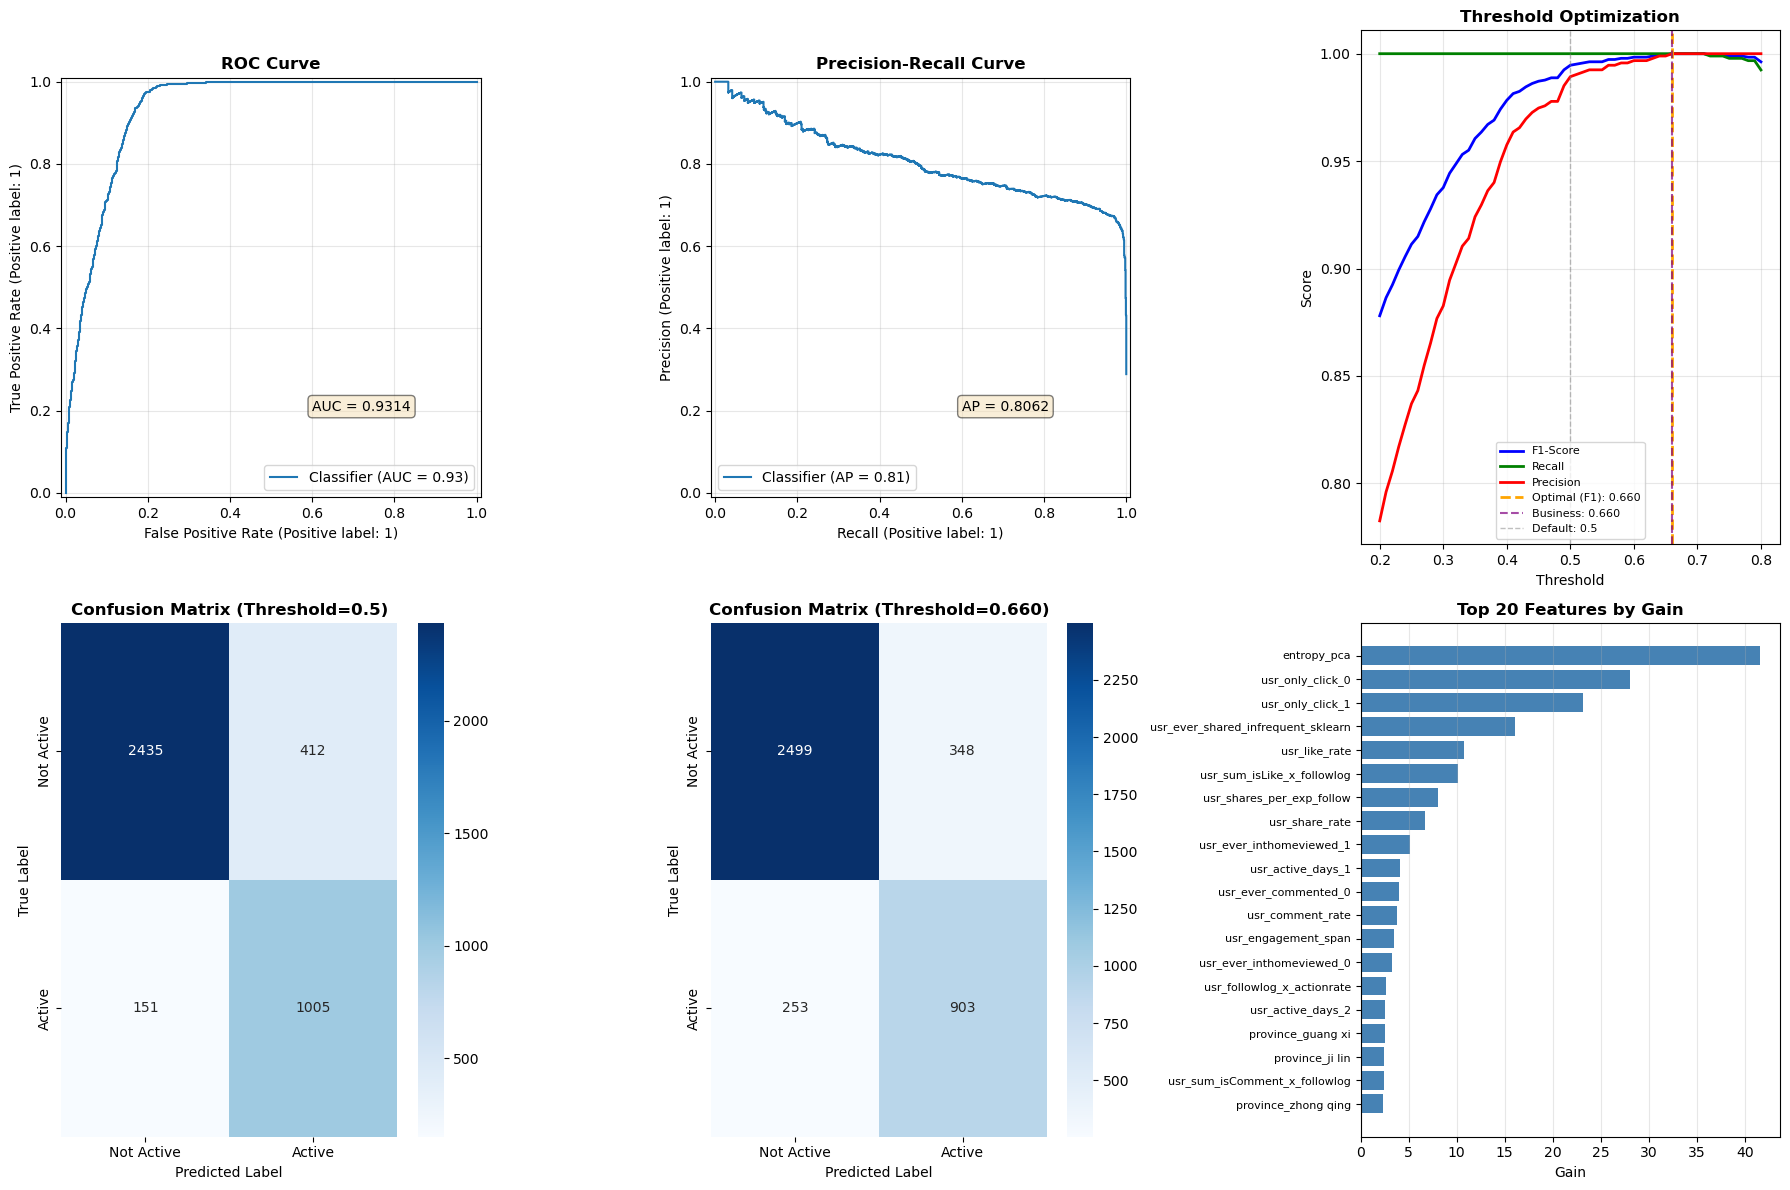


TOP 20 FEATURES BY IMPORTANCE (Multiple Types)
                                     gain   weight   cover total_gain
entropy_pca                         41.57  1938.00  271.29   80554.33
usr_only_click_0                    28.01   653.00  241.87   18287.77
usr_only_click_1                    23.17   294.00  245.02    6812.00
usr_ever_shared_infrequent_sklearn  16.08     2.00  386.07      32.16
usr_like_rate                       10.72   471.00  152.45    5050.54
usr_sum_isLike_x_followlog          10.14   606.00  189.18    6142.50
usr_shares_per_exp_follow            8.00    37.00  569.68     296.09
usr_share_rate                       6.67    26.00  421.99     173.38
usr_ever_inthomeviewed_1             5.08    76.00  198.31     386.45
usr_active_days_1                    4.11   189.00  194.73     776.27
usr_ever_commented_0                 4.00     6.00  599.83      23.99
usr_comment_rate                     3.75    20.00  424.71      75.00
usr_engagement_span                  3.50 

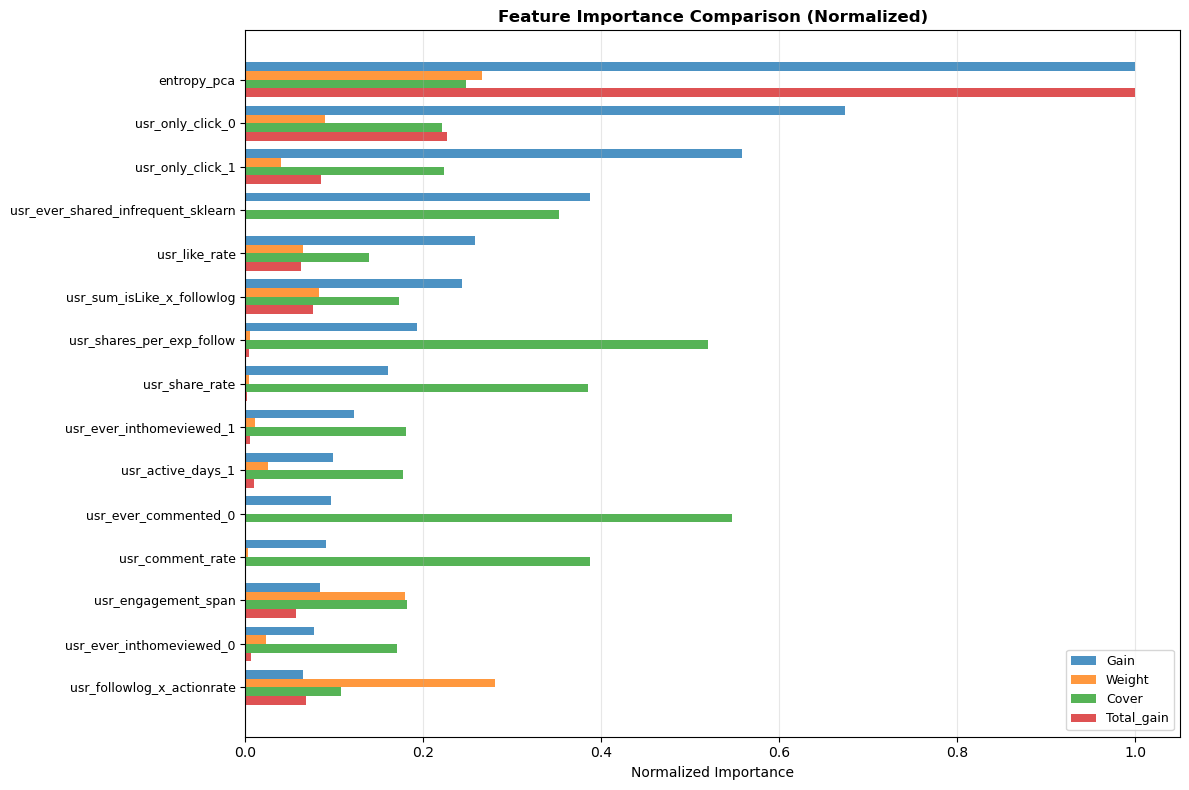

In [66]:
### 6.3. Visualizations

# Visualizations
print("\nROC-AUC Score and Curve:")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

RocCurveDisplay.from_predictions(y_test, proba, ax=axes[0, 0])
axes[0, 0].set_title("ROC Curve", fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.6, 0.2, f'AUC = {roc_auc_optimal:.4f}', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

print("\nPrecision-Recall Curve:")
PrecisionRecallDisplay.from_predictions(y_test, proba, ax=axes[0, 1])
axes[0, 1].set_title("Precision-Recall Curve", fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].text(0.6, 0.2, f'AP = {pr_auc_optimal:.4f}', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[0, 2].plot(thresholds, f1_scores, 'b-', linewidth=2, label='F1-Score')
axes[0, 2].plot(thresholds, recall_scores, 'g-', linewidth=2, label='Recall')
axes[0, 2].plot(thresholds, precision_scores, 'r-', linewidth=2, label='Precision')
axes[0, 2].axvline(x=optimal_threshold, color='orange', linestyle='--', linewidth=2, label=f'Optimal (F1): {optimal_threshold:.3f}')
axes[0, 2].axvline(x=optimal_business_threshold, color='purple', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Business: {optimal_business_threshold:.3f}')
axes[0, 2].axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Default: 0.5')
axes[0, 2].set_xlabel('Threshold', fontsize=10)
axes[0, 2].set_ylabel('Score', fontsize=10)
axes[0, 2].set_title('Threshold Optimization', fontsize=12, fontweight='bold')
axes[0, 2].legend(fontsize=8)
axes[0, 2].grid(True, alpha=0.3)

sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Not Active', 'Active'], yticklabels=['Not Active', 'Active'])
axes[1, 0].set_title(f"Confusion Matrix (Threshold=0.5)", fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
            xticklabels=['Not Active', 'Active'], yticklabels=['Not Active', 'Active'])
axes[1, 1].set_title(f"Confusion Matrix (Threshold={optimal_threshold:.3f})", fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('True Label')
axes[1, 1].set_xlabel('Predicted Label')

# Feature importance - Multiple types
print("\n" + "="*60)
print("COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Collect all importance types
importance_types = ['gain', 'weight', 'cover', 'total_gain']
importance_data = {}

for imp_type in importance_types:
    try:
        score = booster.get_score(importance_type=imp_type)
        if score:
            imp_dict = {}
            for k, v in score.items():
                if k.startswith("f") and len(k) > 1 and k[1:].isdigit():
                    idx = int(k[1:])
                    if idx < len(feature_names):
                        imp_dict[feature_names[idx]] = v
                else:
                    imp_dict[k] = v
            importance_data[imp_type] = imp_dict
    except:
        pass

# Create comprehensive importance dataframe
if importance_data:
    # Get all features
    all_features = set()
    for imp_dict in importance_data.values():
        all_features.update(imp_dict.keys())
    
    # Create dataframe
    imp_df = pd.DataFrame(index=list(all_features))
    for imp_type, imp_dict in importance_data.items():
        imp_df[imp_type] = imp_df.index.map(imp_dict).fillna(0)
    
    # Normalize each column to 0-1 scale for comparison
    for col in imp_df.columns:
        if imp_df[col].max() > 0:
            imp_df[f'{col}_normalized'] = imp_df[col] / imp_df[col].max()
    
    # Sort by gain (most important)
    if 'gain' in imp_df.columns:
        imp_df = imp_df.sort_values('gain', ascending=False)
        top_features = imp_df.head(20)
        
        # Plot gain importance
        axes[1, 2].barh(range(len(top_features)), top_features['gain'].values, color='steelblue')
        axes[1, 2].set_yticks(range(len(top_features)))
        axes[1, 2].set_yticklabels(top_features.index.values, fontsize=8)
        axes[1, 2].set_xlabel("Gain", fontsize=10)
        axes[1, 2].set_title("Top 20 Features by Gain", fontsize=12, fontweight='bold')
        axes[1, 2].invert_yaxis()
        axes[1, 2].grid(True, alpha=0.3, axis='x')
    else:
        axes[1, 2].text(0.5, 0.5, "No feature importance available", 
                        ha='center', va='center', transform=axes[1, 2].transAxes)
        axes[1, 2].set_title("Feature Importance", fontsize=12, fontweight='bold')
else:
    axes[1, 2].text(0.5, 0.5, "No feature importance available", 
                    ha='center', va='center', transform=axes[1, 2].transAxes)
    axes[1, 2].set_title("Feature Importance", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print comprehensive importance table
if importance_data and 'gain' in importance_data:
    print("\n" + "="*60)
    print("TOP 20 FEATURES BY IMPORTANCE (Multiple Types)")
    print("="*60)
    
    # Create display dataframe
    display_cols = [col for col in ['gain', 'weight', 'cover', 'total_gain'] if col in imp_df.columns]
    display_df = imp_df[display_cols].head(20).copy()
    
    # Format for display
    for col in display_cols:
        if display_df[col].dtype in [np.float64, np.float32]:
            display_df[col] = display_df[col].apply(lambda x: f"{x:.2f}" if pd.notna(x) else "N/A")
    
    print(display_df.to_string())
    
    # Feature importance comparison plot
    if len(display_cols) > 1:
        print("\n" + "="*60)
        print("FEATURE IMPORTANCE COMPARISON (Top 15 Features)")
        print("="*60)
        
        fig, ax = plt.subplots(figsize=(12, 8))
        top_15 = imp_df.head(15)
        
        x = np.arange(len(top_15))
        width = 0.2
        
        for i, col in enumerate(display_cols[:4]):  # Max 4 types
            if col in top_15.columns:
                normalized_col = f'{col}_normalized'
                if normalized_col in top_15.columns:
                    ax.barh(x + i*width, top_15[normalized_col].values, width, 
                           label=col.capitalize(), alpha=0.8)
        
        ax.set_yticks(x + width * (len(display_cols[:4]) - 1) / 2)
        ax.set_yticklabels(top_15.index.values, fontsize=9)
        ax.set_xlabel('Normalized Importance', fontsize=10)
        ax.set_title('Feature Importance Comparison (Normalized)', fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.invert_yaxis()
        ax.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()



Feature importance (SHAP values):
SHAP library available. Computing SHAP values...

Generating SHAP summary plot...


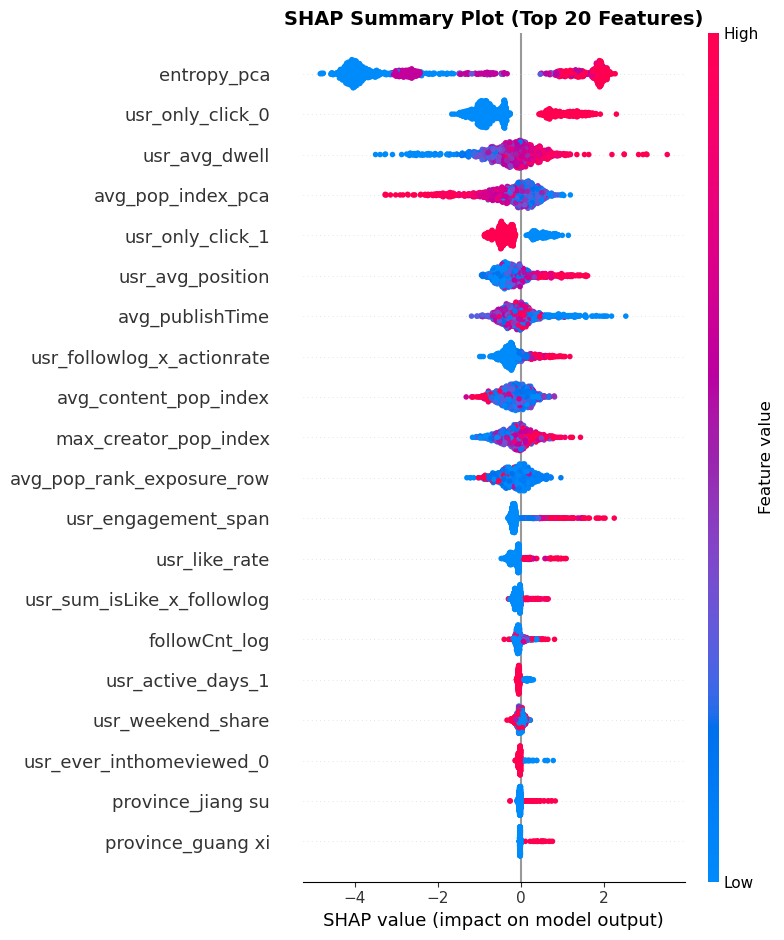


TOP 20 FEATURES BY SHAP IMPORTANCE
                   feature  shap_importance
               entropy_pca         2.784641
          usr_only_click_0         0.879977
             usr_avg_dwell         0.545914
         avg_pop_index_pca         0.508582
          usr_only_click_1         0.441606
          usr_avg_position         0.375075
           avg_publishTime         0.340745
usr_followlog_x_actionrate         0.292943
     avg_content_pop_index         0.288708
     max_creator_pop_index         0.284131
 avg_pop_rank_exposure_row         0.273012
       usr_engagement_span         0.254626
             usr_like_rate         0.172180
usr_sum_isLike_x_followlog         0.097467
             followCnt_log         0.084863
         usr_active_days_1         0.064746
         usr_weekend_share         0.060679
  usr_ever_inthomeviewed_0         0.036675
         province_jiang su         0.034300
         province_guang xi         0.025391

Generating SHAP waterfall plot for exam

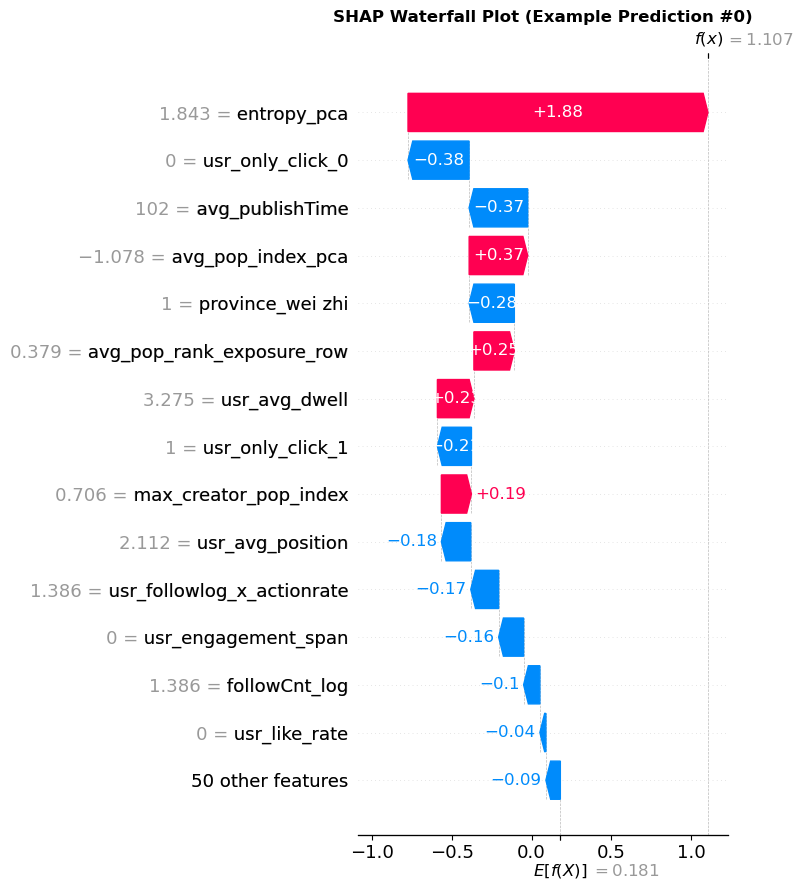

In [67]:
### 6.4. Feature Importance Analysis (SHAP Values)

# Feature importance (SHAP values)
print("\n" + "="*60)
print("\nFeature importance (SHAP values):")
try:
    import shap
    print("SHAP library available. Computing SHAP values...")
    
    # Create a small sample for SHAP (SHAP can be slow on large datasets)
    sample_size = min(1000, len(X_test_t))
    sample_indices = np.random.choice(len(X_test_t), sample_size, replace=False)
    X_test_sample = X_test_t[sample_indices]
    
    # Create SHAP explainer
    explainer = shap.TreeExplainer(booster)
    shap_values = explainer.shap_values(X_test_sample)
    
    # Summary plot
    print("\nGenerating SHAP summary plot...")
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, 
                     max_display=20, show=False)
    plt.title("SHAP Summary Plot (Top 20 Features)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Feature importance from SHAP
    shap_importance = pd.DataFrame({
        'feature': feature_names,
        'shap_importance': np.abs(shap_values).mean(0)
    }).sort_values('shap_importance', ascending=False)
    
    print("\n" + "="*60)
    print("TOP 20 FEATURES BY SHAP IMPORTANCE")
    print("="*60)
    print(shap_importance.head(20).to_string(index=False))
    
    # Waterfall plot for a single prediction (example)
    print("\nGenerating SHAP waterfall plot for example prediction...")
    example_idx = 0
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[example_idx],
        base_values=explainer.expected_value,
        data=X_test_sample[example_idx],
        feature_names=feature_names
    ), max_display=15, show=False)
    plt.title(f"SHAP Waterfall Plot (Example Prediction #{example_idx})", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("SHAP library not installed. Install with: pip install shap")
    print("Skipping SHAP analysis...")
except Exception as e:
    print(f"SHAP analysis encountered an error: {e}")
    print("Continuing without SHAP values...")